In [1]:
# Import necessary libraries
import os
import re
import yaml

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from collections import defaultdict

In [2]:
# Mount Google Drive
from google.colab import drive

print("Mounting Google Drive...")
try:
    drive.mount('/content/drive')
except Exception as e:
    print(f"Failed to mount Google Drive: {e}")

Mounting Google Drive...
Mounted at /content/drive


In [3]:
# Define the path to the dbt project
DBT_DIR = '/content/drive/MyDrive/dbt_projects'
PROJECT_NAME = "dbt_my_project"
PROJECT_PATH = f"{DBT_DIR}/{PROJECT_NAME}"

In [4]:
# Change to the dbt project directory
os.chdir(PROJECT_PATH)

In [5]:
def extract_models_dependencies_and_tests(models_path):
    models = []
    dependencies = []

    # Regex to capture {{ source('schema', 'table') }}
    regex_source = re.compile(r"source\(\s*'([^']+)'\s*,\s*'([^']+)'\s*\)")

    for root, _, files in os.walk(models_path):
        for file in files:
            if file.endswith(".sql"):
                relative_path = os.path.relpath(os.path.join(root, file), models_path)
                model_name = os.path.splitext(relative_path.replace(os.sep, "_"))[0]
                models.append(model_name)

                with open(os.path.join(root, file)) as f:
                    content = f.read()

                    # Extract {{ ref('...') }} dependencies
                    refs = re.findall(r"ref\(\s*'([^']+)'\s*\)", content)
                    for ref in refs:
                        dependencies.append((model_name, f"{ref}"))

                    # Extract {{ source('...', '...') }} dependencies
                    sources = regex_source.findall(content)
                    for schema, table in sources:
                        source_name = f"{schema}.{table}"
                        dependencies.append((model_name, source_name))

            elif file.endswith(".yml"):
                with open(os.path.join(root, file)) as f:
                    yml_content = yaml.safe_load(f)
                    if not yml_content:
                        continue
                    if "models" in yml_content:
                        for model in yml_content["models"]:
                            if "name" in model:
                                model_name = model["name"]
                                test_name = f"test_{model_name}"
                                dependencies.append((test_name, model_name))
                                models.append(test_name)

    # Group dependencies by model and remove duplicates
    unique_models = defaultdict(set)
    for target, source in dependencies:
        unique_models[target].add(source)

    # Add models without dependencies
    for model in models:
        if model not in unique_models:
            unique_models[model] = set()

    return [(target, list(sources)) for target, sources in unique_models.items()]

In [6]:
# Extract models and dependencies
models_and_tests = extract_models_dependencies_and_tests(models_path="models")

In [7]:
# Remove 'staging_' prefix from names
models_no_staging = []
for target, sources in models_and_tests:
    clean_target = target.replace("staging_", "")
    clean_sources = [src.replace("staging_", "") for src in sources]
    models_no_staging.append((clean_target, clean_sources))


In [8]:
# Remove 'marts_' prefix from names
models_no_marts = []
for target, sources in models_no_staging:
    clean_target = target.replace("marts_", "")
    clean_sources = [src.replace("marts_", "") for src in sources]
    models_no_marts.append((clean_target, clean_sources))

models_and_tests = models_no_marts

In [9]:
# Print all dependencies, one per line
for dep in models_and_tests:
    print(dep)

('bronze_investment', ['sample_data.marketing_data'])
('silver_investment', ['bronze_investment'])
('gold_investment', ['silver_investment'])
('bronze_kpi', ['sample_data.marketing_data'])
('silver_kpi', ['bronze_kpi'])
('gold_kpi', ['silver_kpi'])
('bronze_auxiliar', ['sample_data.marketing_data'])
('silver_auxiliar', ['bronze_auxiliar'])
('gold_auxiliar', ['silver_auxiliar'])
('test_gold_investment', ['gold_investment'])
('test_gold_kpi', ['gold_kpi'])
('test_gold_auxiliar', ['gold_auxiliar'])


In [10]:
# Create a directed graph
G = nx.DiGraph()
for target, sources in models_and_tests:
    G.add_node(target)
    for source in sources:
        G.add_node(source)
        G.add_edge(source, target)

In [11]:
# Categorize models by layer
layers = {
    "source": [],
    "bronze": [],
    "silver": [],
    "gold": [],
    "test": [],
    "others": []
}

for model, sources in models_and_tests:
    if model.startswith("bronze"):
        layers["bronze"].append(model)
    elif model.startswith("silver"):
        layers["silver"].append(model)
    elif model.startswith("gold"):
        layers["gold"].append(model)
    elif model.startswith("test"):
        layers["test"].append(model)
    else:
        layers["others"].append(model)

    for source in sources:
        if "." in source and source not in layers["source"]:
            layers["source"].append(source)

In [12]:
def generate_layout_by_group_and_gold_test(layers):
    pos = {}
    spacing_x = 5
    spacing_y = 3

    groups = ['investment', 'kpi', 'auxiliar']
    layer_order = ['source', 'bronze', 'silver', 'gold_test', 'others']

    group_x_map = {group: idx * spacing_x for idx, group in enumerate(groups)}
    center_x = sum(group_x_map.values()) / len(group_x_map)

    for layer_idx, layer in enumerate(layer_order):
        y = -layer_idx * spacing_y

        if layer in ['bronze', 'silver']:
            for group in groups:
                name = f"{layer}_{group}"
                if name in layers.get(layer, []):
                    x = group_x_map[group]
                    pos[name] = (x, y)

        elif layer == 'gold_test':
            for group in groups:
                gold_name = f"gold_{group}"
                test_name = f"test_gold_{group}"
                x_base = group_x_map[group]
                if gold_name in layers.get('gold', []):
                    pos[gold_name] = (x_base, y)
                if test_name in layers.get('test', []):
                    pos[test_name] = (x_base + 1.5, y)

        elif layer == 'source':
            source_nodes = layers.get('source', [])
            total_width = (len(groups) - 1) * spacing_x
            offset = center_x - (len(source_nodes) - 1) * spacing_x / 2
            for i, node in enumerate(source_nodes):
                x = i * spacing_x + offset
                pos[node] = (x, y)

        elif layer == 'others':
            other_nodes = layers.get('others', [])
            for j, node in enumerate(other_nodes):
                x = j * spacing_x
                pos[node] = (x, y)

    return pos

In [13]:
pos = generate_layout_by_group_and_gold_test(layers)

In [14]:
# Print missing nodes (nodes without position)
missing = [n for n in G.nodes if n not in pos]
print("Nodes without position:", missing)

Nodes without position: []


In [15]:
# Define node formatting by layer
formats = {
    "source": {"shape": "h", "color": "#e0e0e0"},       # light gray
    "bronze": {"shape": "o", "color": "#cd7f32"},       # bronze
    "silver": {"shape": "s", "color": "#c0c0c0"},       # silver
    "test": {"shape": "d", "color": "#e6ccff"},         # light purple
    "gold": {"shape": "^", "color": "#ffd700"},         # gold
    "others": {"shape": "8", "color": "#f8d7da"},       # light red
}

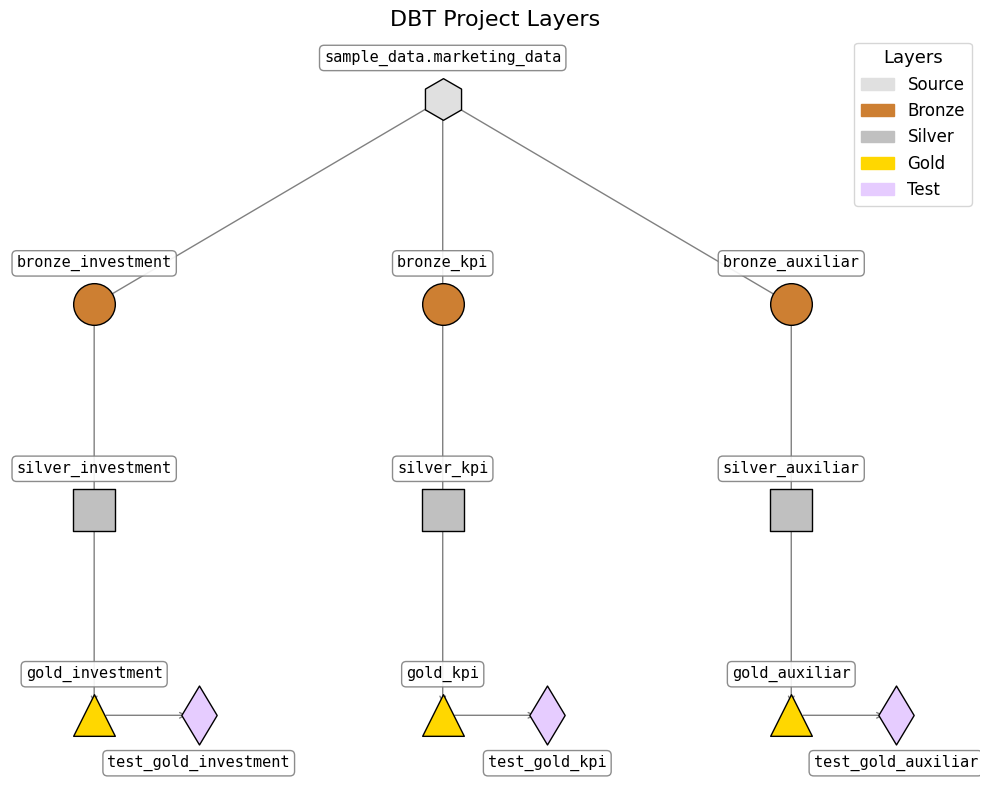

In [16]:
# Plot the graph
plt.figure(figsize=(10, 8))
legend = {}

# Draw nodes by layer
for layer, nodes in layers.items():
    if not nodes:
        continue
    props = formats[layer]
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodes,
        node_shape=props["shape"],
        node_color=props["color"],
        label=layer,
        node_size=900,
        edgecolors='black'
    )
    legend[layer] = props

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', edge_color="gray")

# Draw labels
labels = {n: n for n in G.nodes()}
label_pos = {}

for n in G.nodes():
    node_layer = next((layer for layer, nodes in layers.items() if n in nodes), None)
    if node_layer == "test":
        label_pos[n] = (pos[n][0], pos[n][1] - 0.7)
    else:
        label_pos[n] = (pos[n][0], pos[n][1] + 0.6)

nx.draw_networkx_labels(
    G, label_pos,
    labels=labels,
    font_size=11,
    font_family="monospace",
    bbox=dict(
        facecolor="white",
        edgecolor="gray",
        boxstyle="round,pad=0.3",
        alpha=0.9
    )
)

# Create legend
patches = [
    mpatches.Patch(color=props["color"], label=layer.capitalize())
    for layer, props in legend.items()
]
plt.legend(handles=patches, title="Layers", loc="upper right", fontsize=12, title_fontsize=13)

plt.title("DBT Project Layers", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()
